In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



In [2]:
import tensorflow as tf
print(tf.__version__)


2.15.0


#### Read the data

In [3]:
sales_data = pd.read_csv("data_set/train.csv")

sales_data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


#### check for null values

In [4]:
sales_data.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [5]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


#### Dropping store and Item coloumns

In [6]:
sales_data = sales_data.drop(['store', 'item'], axis=1)

sales_data.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


In [7]:
sales_data['date'].dtype

dtype('O')

#### convert date to date format

In [8]:
sales_data['date'] = pd.to_datetime(sales_data['date'])

sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


In [9]:
sales_data.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


#### converting date to a Month period and then sum the number of items in each month

In [10]:
sales_data['date'] = sales_data['date'].dt.to_period("M")

monthly_sales = sales_data.groupby('date').sum().reset_index()

monthly_sales.head()

,date,sales
0,2013-01,454904
1,2013-02,459417
2,2013-03,617382
3,2013-04,682274
4,2013-05,763242


#### converting the resulting date column to timestamp datatype

In [11]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

monthly_sales.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


#### Visualize the monthly sales

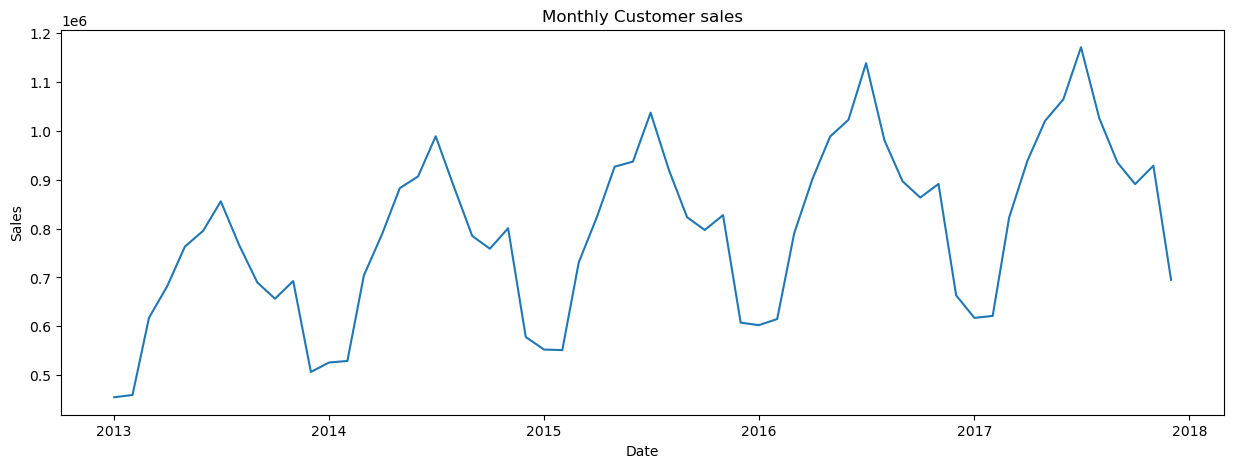

In [12]:
plt.figure(figsize=(15,5))

plt.plot(monthly_sales['date'], monthly_sales['sales'])

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer sales")
plt.show()

#### call the difference on the sales coloumns to make the sales data stationery

In [18]:
""" The .diff() method calculates the difference between each row and the previous row in the sales column. """

monthly_sales['sales_diff'] = monthly_sales['sales'].diff()

monthly_sales.head(20)



,date,sales,sales_diff
0,2013-01-01,454904,NaN
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
